# Sentiment Analysis Model Evaluation
This notebook evaluates the performance of our sentiment analysis model using the Amazon Review Dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from transformers import pipeline
import torch
import sys
sys.path.append('../')
from functions.main_function import predict_sentiment, get_device

/Users/danielqvu/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Test Data

In [13]:
# Load test data
test_data = pd.read_csv('test.csv', header=None, names=['rating', 'title', 'text'])
# Sample a smaller subset for faster evaluation
test_sample = test_data.sample(n=100)
print(f'Sample size: {len(test_sample)}')

Sample size: 100


/var/folders/8b/6hqn4pk525z062z8jxyjv_vm0000gn/T/ipykernel_34624/218303703.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('test.csv', header=None, names=['rating', 'title', 'text'])


## Evaluate Model Performance

In [ ]:
def map_sentiment_to_rating(sentiment_result):
    # Return neutral (3) if no result
    if not sentiment_result or not isinstance(sentiment_result, list) or not sentiment_result:
        return 3
    
    # Get the prediction dictionary from the list
    prediction = sentiment_result[0]
    if not isinstance(prediction, dict) or 'label' not in prediction:
        return 3
    
    # Direct mapping from sentiment labels to ratings
    sentiment_map = {
        'Very Negative': 1,
        'Negative': 2,
        'Neutral': 3,
        'Positive': 4,
        'Very Positive': 5
    }
    
    # Get the sentiment label and return corresponding rating
    label = prediction['label']
    return sentiment_map.get(label, 3)  # Default to neutral (3) if label not found

# Get predictions
predictions = []
true_pred = []
for text in test_sample['text']:
    result = predict_sentiment(text)
    true_pred.append(result)
    predictions.append(map_sentiment_to_rating(result))

# Convert predictions to numpy array
predictions = np.array(predictions)
true_ratings = test_sample['rating'].values

## Visualization and Analysis

In [16]:
# Convert true_pred to numerical ratings (2-4)
pred = []
print(true_pred)
for item in true_pred:
    sentiment = list(item.keys())[0]
    if sentiment in ['Very Negative', 'negative']:
        pred.append(2)
    elif sentiment == 'neutral':
        pred.append(3)
    elif sentiment in ['Very Positive', 'positive']:
        pred.append(4)

# Convert true_ratings to integer array and map 1-5 to 2-4
true_ratings = np.array(true_ratings).astype(int)
# Map 1 to 2 and 5 to 4å√
true_ratings = np.where(true_ratings == 1, 2, true_ratings)
true_ratings = np.where(true_ratings == 5, 4, true_ratings)

print("Predicted ratings:", pred)
print("True ratings:", true_ratings)
print(true_ratings[0])

[{'neutral': 0.7489129304885864}, {'negative': 0.9973956346511841}, {'negative': 0.9737157821655273}, {'neutral': 0.5531409978866577}, {'neutral': 0.6345756649971008}, {'neutral': 0.6040399074554443}, {'positive': 0.9327795505523682}, {'neutral': 0.4962480068206787}, {'positive': 0.46276864409446716}, {'negative': 0.9958539009094238}, {'neutral': 0.7732943892478943}, {'positive': 0.9916166663169861}, {'positive': 0.8104338645935059}, {'positive': 0.9829311966896057}, {'positive': 0.9979826211929321}, {'negative': 0.9290667772293091}, {'negative': 0.9925146698951721}, {'negative': 0.9362485408782959}, {'positive': 0.9705920815467834}, {'negative': 0.6275873184204102}, {'neutral': 0.7402783632278442}, {'positive': 0.9255673885345459}, {'negative': 0.9999558925628662}, {'positive': 0.9973711967468262}, {'negative': 0.9974709749221802}, {'positive': 0.7390656471252441}, {'positive': 0.7459126710891724}, {'positive': 0.972992479801178}, {'neutral': 0.6022007465362549}, {'negative': 0.999733

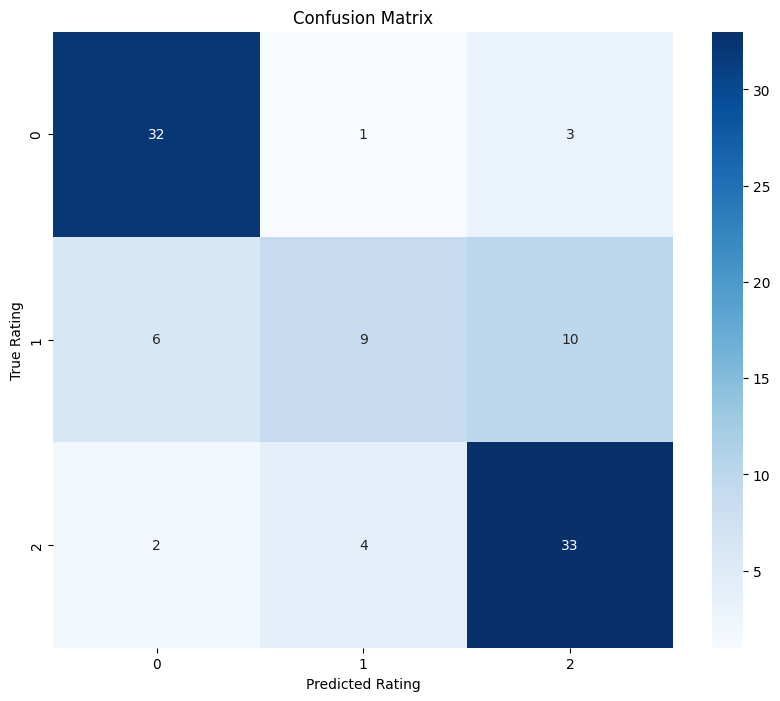

Classification Report:
              precision    recall  f1-score   support

           2       0.80      0.89      0.84        36
           3       0.64      0.36      0.46        25
           4       0.72      0.85      0.78        39

    accuracy                           0.74       100
   macro avg       0.72      0.70      0.69       100
weighted avg       0.73      0.74      0.72       100



In [17]:
# Create confusion matrix
cm = confusion_matrix(true_ratings, pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(true_ratings, pred))

## Error Analysis

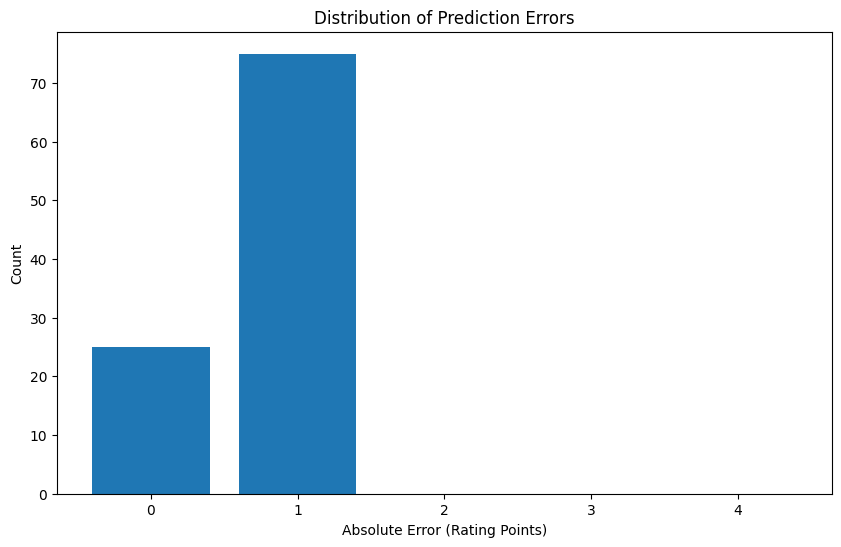

Mean Absolute Error: 0.75
Median Absolute Error: 1.00


In [18]:
# Calculate error distribution
errors = np.abs(true_ratings - predictions)

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=range(6), align='left', rwidth=0.8)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Absolute Error (Rating Points)')
plt.ylabel('Count')
plt.xticks(range(5))
plt.show()

print(f'Mean Absolute Error: {np.mean(errors):.2f}')
print(f'Median Absolute Error: {np.median(errors):.2f}')

## Sample Error Cases

In [24]:
# Find cases with largest prediction errors
test_sample['predicted_rating'] = predictions
test_sample['error'] = errors

print('Top 5 cases with largest prediction errors:')
error_cases = test_sample.nlargest(5, 'error')
for _, case in error_cases.iterrows():
    print(f'True Rating: {case["rating"]}')
    print(f'Predicted Rating: {case["predicted_rating"]}')
    print(f'Text: {case["text"]}')

Top 5 cases with largest prediction errors:
True Rating: 2
Predicted Rating: 3
Text: Not a very good movie. Low production values. No real character development. Very predictable once the basic plot is set. Just not that good.
True Rating: 1
Predicted Rating: 3
Text: It would seem that this can not be watched on an Apple product (ITunes/Ipod/ITouch) which is disappointing to say the least.I am a loyal Amazon user (at least two purchases a month) but this decision to provide episodes (but not for mac users) makes it easier to switch to other suppliers of product.Amazon - you are better than this. Get this resolved for Mac users.
True Rating: 5
Predicted Rating: 3
Text: Loved it as much as when I first saw it on the big screen at the Wintergarden in Sydney way back in the 60's
True Rating: 2
Predicted Rating: 3
Text: The Clean/Dirty magnet was just okay. I thought it would be a flat "all-over" magnet but it is really a cheap piece of plastic stuck onto a medium sized circle magnet. Sure 